# Analysis of Fashion data

## Overview
**Goal:** Use an ANN model from the previous notebook to optimize predictions and create a recommender system to provide outfit recommendations based on product popularity.

### Load our data

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing and tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

### Load the data

In [306]:
# load the modeldata from previous notebook
modeldata_df = pd.read_csv("../data/modeldata_df.csv")
modeldata_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002,low
1,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002,high
2,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002,low
3,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017,medium
4,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017,medium


In [307]:
modeldata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   product_code                105542 non-null  int64 
 1   product_type_no             105542 non-null  int64 
 2   product_group_name          105542 non-null  object
 3   graphical_appearance_no     105542 non-null  int64 
 4   colour_group_code           105542 non-null  int64 
 5   perceived_colour_value_id   105542 non-null  int64 
 6   perceived_colour_master_id  105542 non-null  int64 
 7   department_no               105542 non-null  int64 
 8   index_code                  105542 non-null  object
 9   index_group_no              105542 non-null  int64 
 10  section_no                  105542 non-null  int64 
 11  garment_group_no            105542 non-null  int64 
 12  popularity                  105542 non-null  object
dtypes: int64(10), object(3)
memor

## Feature Selection and Engineering

In [308]:
modeldata_df.columns

Index(['product_code', 'product_type_no', 'product_group_name',
       'graphical_appearance_no', 'colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id',
       'department_no', 'index_code', 'index_group_no', 'section_no',
       'garment_group_no', 'popularity'],
      dtype='object')

Our recommender model is going to use the product group name to recommend outfits, so let's clean that feature up a bit.

In [309]:
modeldata_df["product_group_name"].value_counts()

product_group_name
Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: count, dtype: int64

In [310]:
# drop rows of irrelevant product groups
modeldata_df = modeldata_df[modeldata_df["product_group_name"].isin(["Garment Upper body", "Garment Lower body", "Garment Full body", "Accessories", "Swimwear", "Bags"])]
modeldata_df["product_group_name"].value_counts()

product_group_name
Garment Upper body    42741
Garment Lower body    19812
Garment Full body     13292
Accessories           11158
Swimwear               3127
Bags                     25
Name: count, dtype: int64

We want to map the product name to a number for easier processing.

In [311]:
# map each product group to a number
product_group_mapper = {
    "Garment Upper body": 1,
    "Garment Lower body": 2,
    "Garment Full body": 3,
    "Accessories": 4,
    "Swimwear": 5,
    "Bags": 6,
}

In [312]:
# replace the product_group_name with a number
modeldata_df["product_group_name"] = modeldata_df["product_group_name"].replace(product_group_mapper)
modeldata_df["product_group_name"].value_counts()

product_group_name
1    42741
2    19812
3    13292
4    11158
5     3127
6       25
Name: count, dtype: int64

In [ ]:
# might need to add product names back in here for recommender output

## Artificial Neural Network (ANN)
We want to use an ANN and improve it for our recommender model. 74% was the best our previous ANN could do, using LeakyReLU and a laearning rate scheduler (LRS).

### Train-test split

In [313]:
TARGET = ["popularity"]
X, y = modeldata_df.drop(columns=TARGET, axis=1), modeldata_df[TARGET]

In [314]:
# use encoder helper function on the text columns in X
# for easier analysis
helper.encode_strings(X)

In [315]:
# One-hot encode target variable (for multiclass classification)
y_onehot = pd.get_dummies(y)

In [316]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Tuning: Standard Scaler

In [317]:
# use standard scaler
# check if that will gain better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Modeling: ANN

In [318]:
# Number of features after preprocessing
input_dim = X_train_scaled.shape[1]

# Number of classes (low, medium, high)
output_dim = y_train.shape[1]

input_dim, output_dim

(12, 3)

In [319]:
# Best performing model from previous notebook:
# ANN Model with LeakyRelu and learning rate scheduler
ann_model = helper.ANN(input_size=input_dim, hidden_layers=[64, 32], dropouts=[0.3, 0.3], output_size=output_dim, learning_rate=0.001, leaky=True)
ann_model.model_summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                832       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32)                0         
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 3)                

In [320]:
# Train the model
history = ann_model.train_model(X_train=X_train_scaled, y_train=y_train,
                      X_validation=X_val_scaled, y_validation=y_val,
                      epoch=50, batch_size=32)

Epoch 1/50
1973/1973 [==============================] - 8s 2ms/step - loss: 0.7143 - accuracy: 0.7056 - val_loss: 0.6524 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 2/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6597 - accuracy: 0.7336 - val_loss: 0.6466 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 3/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6499 - accuracy: 0.7379 - val_loss: 0.6415 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 4/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6464 - accuracy: 0.7380 - val_loss: 0.6402 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 5/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6434 - accuracy: 0.7397 - val_loss: 0.6366 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 6/50
1973/1973 [==============================] - 4s 2ms/step - loss: 0.6409 - accuracy: 0.7415 - val_loss: 0.6362 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 7/50
1973/1973 [==============================] - 4s

In [331]:
# Evaluate on the test set
ann_model.evaluate_accuracy(X_test=X_test_scaled, y_test=y_test)

423/423 [==============================] - 1s 1ms/step - loss: 0.6249 - accuracy: 0.7428
Test Accuracy: 0.74


423/423 [==============================] - 0s 1ms/step
confusion matrix:
 [[ 785  578  264]
 [ 105 8583  283]
 [ 411 1838  677]]

              precision    recall  f1-score   support

           0       0.60      0.48      0.54      1627
           1       0.78      0.96      0.86      8971
           2       0.55      0.23      0.33      2926

    accuracy                           0.74     13524
   macro avg       0.65      0.56      0.57     13524
weighted avg       0.71      0.74      0.71     13524



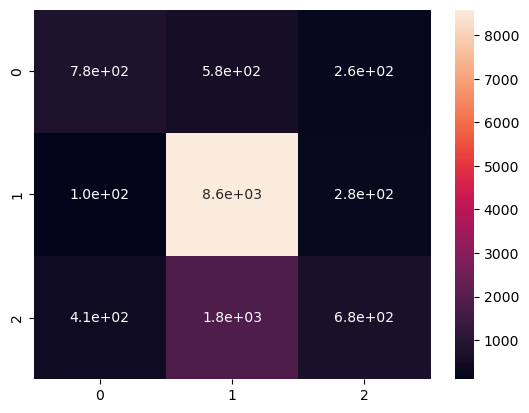

In [332]:
# predict on the model and print confusion matrix
ann_model.predict_model(X_test=X_test_scaled, y_test=y_test)

## Recommendation System

In [333]:
# Generalized Matrix Factorization (GMF)
# GMF-Based Outfit Recommender
class OutfitRecommenderGMF:
    def __init__(self, num_products, num_features, embedding_dim=8, learning_rate=0.001):
        self.num_products = num_products
        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.model = self.initialize_model()
        
    def initialize_model(self):
        # Inputs
        product_input = Input(shape=(1,), name="Product_Input")
        feature_input = Input(shape=(self.num_features,), name="Feature_Input")

        # Embedding layer for product
        product_embedding = Embedding(input_dim=self.num_products, output_dim=self.embedding_dim, name="Product_Embedding")(product_input)
        product_embedding = Flatten()(product_embedding)

        # Concatenate embeddings and features
        concatenated = Concatenate()([product_embedding, feature_input])

        # Dense layer for prediction
        output = Dense(1, activation="linear", name="Output")(concatenated)

        # Compile the model
        model = Model(inputs=[product_input, feature_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="mse", metrics=["mae"])
        return model

    def train(self, product_codes, features, popularity, epochs=100, batch_size=32, verbose=1):
        self.model.fit([product_codes, features], popularity, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

    def predict(self, product_codes, features):
        return self.model.predict([product_codes, features])

    def recommend_outfit(self, product_codes, features, original_df, preference="popular"):
        predictions = self.predict(product_codes, features)
        if preference == "popular":
            recommended_idx = np.argmax(predictions)
        else:  # Alternative, less popular
            recommended_idx = np.argmin(predictions)
        return original_df.iloc[recommended_idx]

In [ ]:
"""
categorical_features = ['product_group_name', 'index_code']
for feature in categorical_features:
    le = LabelEncoder()
    modeldata_df[feature] = le.fit_transform(modeldata_df[feature])
"""

# helper.encode_strings(modeldata_df)

In [325]:
product_codes = modeldata_df["product_code"].values
features = modeldata_df.drop(["popularity", "product_code"], axis=1).values
popularity = modeldata_df["popularity"].values

In [326]:
# standard scaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [327]:
prod_train, prod_test, feat_train, feat_test, pop_train, pop_test = train_test_split(
        product_codes, features, popularity, test_size=0.2, random_state=42)

In [328]:
product_encoder = LabelEncoder()
modeldata_df_copy = modeldata_df
modeldata_df_copy["product_code"] = product_encoder.fit_transform(modeldata_df_copy["product_code"])

product_codes = modeldata_df_copy["product_code"].values

len(product_encoder.classes_)

41026

In [329]:
len(modeldata_df["product_code"].value_counts().index)

41026

In [330]:
 # Create and Train the Model
num_products = len(modeldata_df["product_code"].value_counts().index)

recommender = OutfitRecommenderGMF(num_products=num_products, num_features=features.shape[1], embedding_dim=8, learning_rate=0.001)
recommender.train(prod_train, feat_train, pop_train, epochs=200, batch_size=16)

Epoch 1/200


2024-12-12 23:18:37.977089: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: indices[0,0] = 925664 is not in [0, 41026)
	 [[{{node model_7/Product_Embedding/embedding_lookup}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'model_7/Product_Embedding/embedding_lookup' defined at (most recent call last):
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_48105/408820654.py", line 5, in <module>
      recommender.train(prod_train, feat_train, pop_train, epochs=200, batch_size=16)
    File "/var/folders/8g/m6zcqnnd1p36dhf35mwkv0zw0000gn/T/ipykernel_48105/2608761856.py", line 32, in train
      self.model.fit([product_codes, features], popularity, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/Cohort-Env/lib/python3.8/site-packages/keras/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_7/Product_Embedding/embedding_lookup'
indices[0,0] = 925664 is not in [0, 41026)
	 [[{{node model_7/Product_Embedding/embedding_lookup}}]] [Op:__inference_train_function_13421030]

## Getting User Input

In [341]:
# ask customer for user input

# give multiple choice
user_outfit_type = int(input("What type of garmet are you looking for? Top: 1, Bottoms: 2, Dress: 3, Accessories: 4, Swimwear: 5, Bags: 6"))

# give multiple choice
user_preference = int(input("Do you want something popular or alternative? Popular: 1, Alternative: 2"))

In [342]:
# Filter Data Based on User Input
filtered_df = modeldata_df[modeldata_df["product_group_name"] == user_outfit_type]
filtered_product_codes = filtered_df["product_code"].values
filtered_features = scaler.transform(filtered_df.drop(["popularity", "product_code"], axis=1).values)

In [ ]:
# need to change it to be the product name from the code
recommended_outfit = recommender.recommend_outfit(filtered_product_codes, filtered_features, modeldata_df, preference=user_preference)
print("Recommended Outfit Based on Your Preference:\n", recommended_outfit["product_code"])

416/416 [==============================] - 1s 1ms/step
Recommended Outfit Based on Your Preference:
 1820
